In [1]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import torch.nn as nn
import IPython.display as ipd
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torchmetrics

In [2]:
class CFG:
    sr=16000
    n_fft=1024
    hop_length=512 #Length of hop between STFT windows, 
    n_mels=48
    dataset_list = ["dev-clean", "dev-other", "test-clean", "test-other", 
                    "train-clean-100","train-clean-360", "train-other-500"]
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    #win_length default is same as n_fft,
    #hop_length default value is same as win_length//2
    #more info:
    #https://pytorch.org/audio/main/generated/torchaudio.transforms.MelSpectrogram.html: 

In [3]:
class LibriSpeechDataset(torch.utils.data.Dataset):
    
    def __init__(self, split=CFG.dataset_list[2], device = CFG.DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        '''
        split parameter is parameter for choosing dataset of LibriSpeechDataset
        you can choose bellow:
        "dev-clean", "dev-other", "test-clean",
        "test-other", "train-clean-100", "train-clean-360" 
        and "train-other-500"
        more info check this url
        https://pytorch.org/audio/stable/generated/torchaudio.datasets.LIBRISPEECH.html#torchaudio.datasets.LIBRISPEECH
        '''
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=CFG.sr, n_fft=CFG.n_fft, hop_length=CFG.hop_length, n_mels=CFG.n_mels)
        self.db_converter = torchaudio.transforms.AmplitudeToDB() #convert value to log
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000

        log_mel_spec = self.db_converter(self.mel_converter(audio))
        
        return (log_mel_spec, text)
      
    def checkSound(self, itemIndex):
        audio, sample_rate, text, _, _, _ = self.dataset[itemIndex]
        ipd.display(ipd.Audio(audio, rate=CFG.sr))
        print(text)
    
    def checkLogMelSpec(self, itemIndex):
        audio, sample_rate, text, _, _, _ = self.dataset[itemIndex]
        log_mel_spec = self.db_converter(self.mel_converter(audio))
        self.plot_spectrogram(log_mel_spec[0], title="LogMelSpectrogram", ylabel="mel freq")
        print(text)
        
    def plot_spectrogram(self, specgram, title=None, ylabel="freq_bin"):
        fig, axs = plt.subplots(1, 1, figsize=(10, 4))
        axs.set_title(title or "Spectrogram")
        axs.set_ylabel(ylabel)
        axs.set_xlabel("frame")
        im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
        fig.colorbar(im, ax=axs)
        plt.show(block=False)

In [4]:
dataset = LibriSpeechDataset("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

  0%|          | 0.00/331M [00:00<?, ?B/s]

AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS


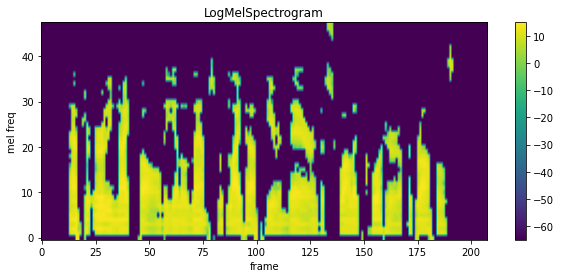

AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS


In [5]:
dataset.checkSound(2)
dataset.checkLogMelSpec(2)